[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD?labpath=feature_extraction.ipynb)

In [1]:
%matplotlib inline

import cv2
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from collections import Counter
from joblib import cpu_count, delayed, Parallel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from displaytools import *
from improcessing import *
from rfextraction import *

# Read in image file

In [2]:
image_stack = cv2.imreadmulti('source_images/suspension_colour.tiff',
                              flags=cv2.IMREAD_GRAYSCALE)[1]

# Extract mask image

Using mode 'thresh_adaptive'.
Denoising with intensity 3.
Applying adaptive thresholding with kernel size of 151 and C=8.
Unmasking areas without edges using Canny[130, 180]:
Removing border of 2 pixels.
Closing with kernel size of 8.
Unmasking regions smaller than 250 pixels.


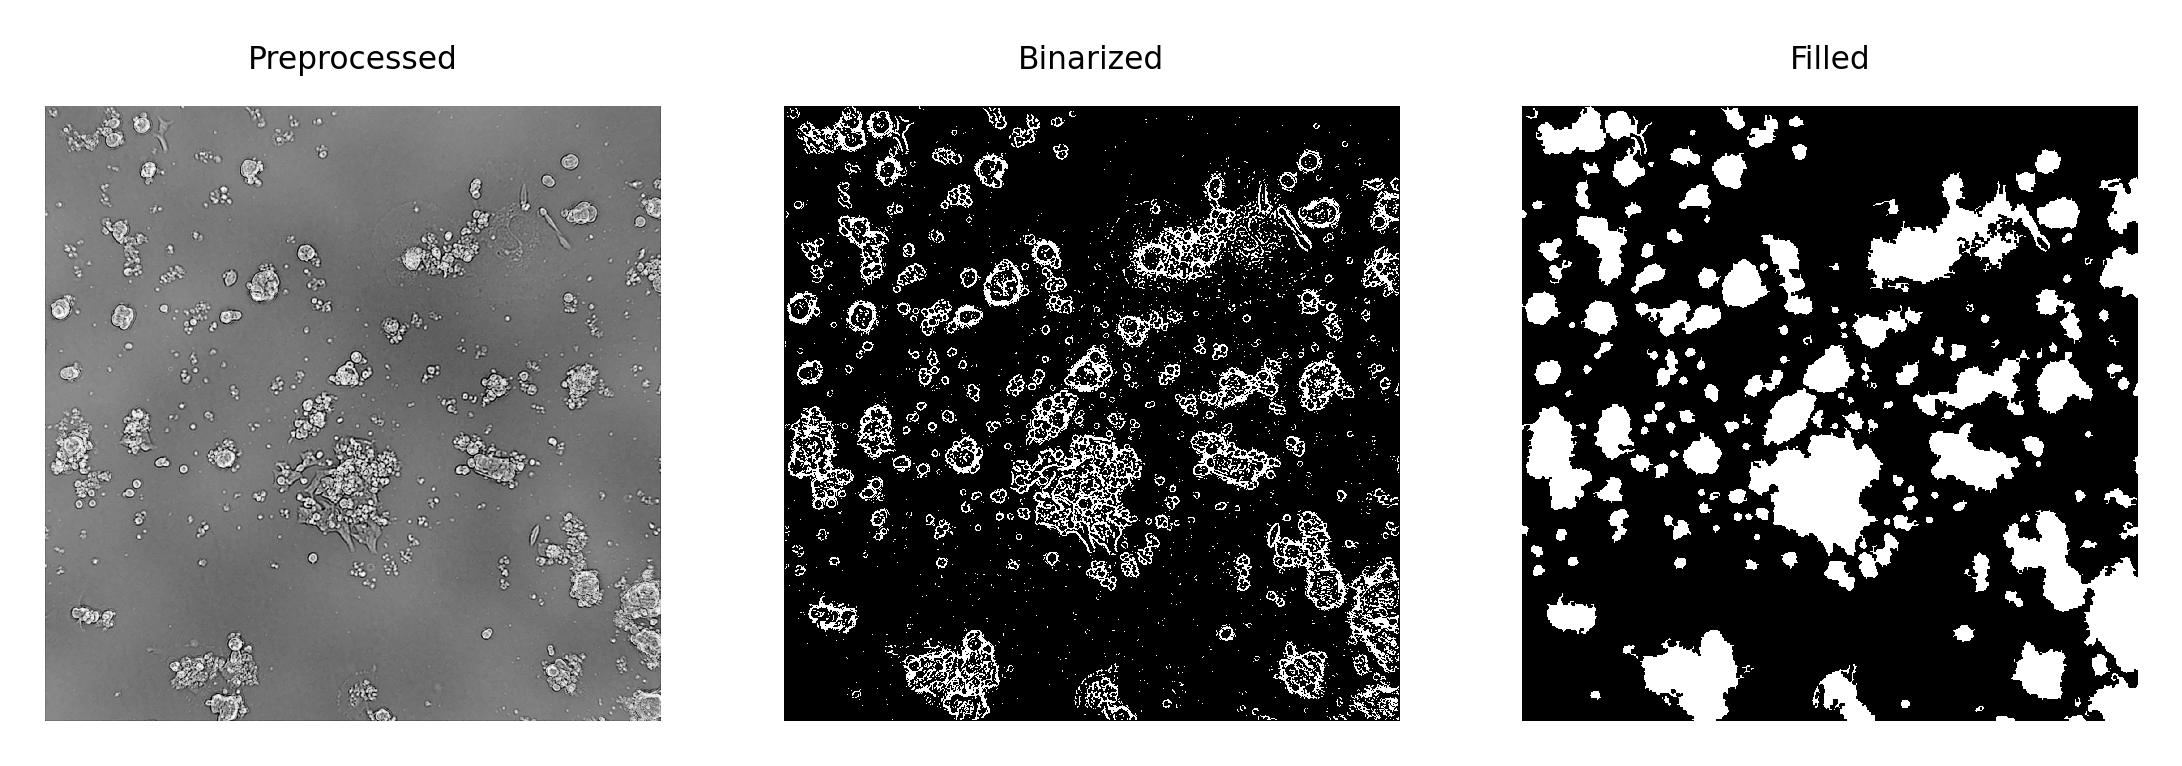

In [3]:
image_gray = scale_image(image_stack[1])
mask_image = get_mask_image(image_gray, 'params_gray_mask.yml', verbosity=2)

# Extract features, then standardize and reduce dimensions

In [4]:
df, mask_labels = extract_features(image_gray, mask_image)
display(df)

original_shape2D_Elongation  original_shape2D_MajorAxisLength  \
x    y                                                                     
211  89                       0.349330                        358.909367   
688  43                       0.571093                         83.631183   
38   30                       0.646268                         46.070021   
781  91                       0.537323                        123.679389   
885  54                       0.726848                         45.060190   
...                                ...                               ...   
1796 1932                     0.710086                         28.779445   
1239 1936                     0.890307                         30.753223   
1478 1952                     0.505167                         33.336111   
1791 1983                     0.308302                         65.817336   
1559 1984                     0.260779                         64.533728   

          original_shape2D_MaximumDiameter original_shape2D_MeshSurface  \
x    y                                                                    
211  89                  380.6691476860188                      28052.5   
688  43                  95.67131231461184                       2995.5   
38   30                   42.5440947723653                        390.5   
781  91                 120.22063050907694                       5429.5   
885  54                  48.83646178829912                       1096.5   
...                                    ...                          ...   
1796 1932                31.25699921617557                        365.5   
1239 1936               31.953090617340916                        655.5   
1478 1952               30.364452901377952                        278.5   
1791 1983                72.56031973468694                        877.5   
1559 1984                61.40032573203501                        778.5   

           original_shape2D_MinorAxisLength original_shape2D_Perimeter  \
x    y                                                                   
211  89                          125.377764         1753.8864350759834   
688  43                           47.761202           278.308657865102   
38   30                           29.773586           155.154328932551   
781  91                           66.455756          533.9066376115492   
885  54                           32.751894          154.9116882454316   
...                                     ...                        ...   
1796 1932                         20.435873         111.35533905932752   
1239 1936                         27.379819         101.01219330881983   
1478 1952                         16.840296         119.01219330881995   
1791 1983                         20.291641         185.25483399593924   
1559 1984                         16.829017         147.11269837220814   

          original_shape2D_PerimeterSurfaceRatio  \
x    y                                             
211  89                        0.062521573302771   
688  43                      0.09290891599569422   
38   30                        0.397322225179388   
781  91                       0.0983344023596186   
885  54                        0.141278329453198   
...                                          ...   
1796 1932                    0.30466577034015735   
1239 1936                     0.1540994558486954   
1478 1952                     0.4273328305523158   
1791 1983                    0.21111661993839229   
1559 1984                    0.18896942629699184   

           original_shape2D_PixelSurface  original_shape2D_Sphericity  \
x    y                                                                  
211  89                          28053.0                     0.338524   
688  43                           2996.0                     0.697129   
38   30                            391.0                     0.451494   
781  91                           5430.0 

In [5]:
scaler = StandardScaler()
pca = PCA(n_components='mle')

scaled = scaler.fit_transform(df)
dft = pd.DataFrame(pca.fit_transform(scaled), index=df.index)
display(dft)

0         1         2         3         4         5   \
x    y                                                                   
211  89    -6.134212  5.835813 -5.443318  0.675405 -1.769964 -1.988987   
688  43    -2.058094 -1.205069 -3.202366  0.333854 -2.142587 -1.559690   
38   30    11.653061  2.913152 -0.009834  0.714693 -0.309295 -1.599943   
781  91    -0.391478  0.302709 -7.352755  1.101301 -1.995452 -2.878390   
885  54    -0.372284 -2.379750 -1.203120 -1.072941 -1.090334 -0.290313   
...              ...       ...       ...       ...       ...       ...   
1796 1932   3.965560 -1.724818  1.533440 -3.115898  0.743441 -1.373119   
1239 1936   1.215363 -1.994374  0.083045 -0.666712 -0.382132  1.234835   
1478 1952  10.186812  1.594883  3.374890 -3.124386 -0.461183 -1.719590   
1791 1983  -5.026170 -1.529610  3.937014  0.035477 -1.837338 -1.138384   
1559 1984  -0.905291 -1.448543  2.382443 -2.698174 -2.130141 -2.756419   

                 6         7         8         9   ...        87        88  \
x    y                                             ...                       
211  89    1.340395  2.025219  2.032397 -1.012213  ...  0.002633  0.000388   
688  43   -0.023798 -0.771874 -0.257029 -0.243679  ... -0.007777 -0.002166   
38   30   -3.366022 -0.599252 -0.193768  1.205104  ...  0.000130 -0.000989   
781  91    1.474832  1.696274  0.859143 -1.520856  ... -0.003954 -0.001491   
885  54    0.906693 -1.379350  0.038031  0.880014  ... -0.002745  0.001446   
...             ...       ...       ...       ...  ...       ...       ...   
1796 1932 -0.008892 -0.989738  1.601971 -0.235012  ... -0.003097  0.000805   
1239 1936 -0.798314 -0.982272 -1.202570 -0.531453  ...  0.002934 -0.005471   
1478 1952 -1.403322  0.478685  2.150388  0.259574  ...  0.002184 -0.000127   
1791 1983 -0.662695 -0.849301  3.138237  0.578383  ...  0.005898  0.005779   
1559 1984 -2.448526  0.726947  1.462550 -0.454180  ... -0.002932  0.006734   

                 89        90        91        92        93        94  \
x    y                                                                  
211  89    0.001782  0.002484 -0.001443 -0.001245 -0.002749  0.000011   
688  43    0.003047 -0.001440 -0.000102 -0.000859  0.003518  0.000062   
38   30    0.000958  0.000329 -0.000128 -0.000196  0.000197  0.000031   
781  91   -0.000617  0.003125 -0.003211  0.000420  0.000689  0.000190   
885  54   -0.007690  0.004964 -0.005238  0.000631  0.003304 -0.000200   
...             ...       ...       ...       ...       ...       ...   
1796 1932  0.002236 -0.000155  0.002966  0.004797  0.003154  0.000193   
1239 1936  0.003621 -0.001936  0.006288 -0.001182  0.002788 -0.000079   
1478 1952  0.005057 -0.001705  0.000460 -0.000057 -0.001930 -0.000174   
1791 1983 -0.003870 -0.004607 -0.005087  0.001093  0.000323  0.000196   
1559 1984 -0.003798 -0.005391 -0.001418 -0.004445  0.000808 -0.000277   

                     95            96  
x    y                                 
211  89   -6.996999e-06 -3.236885e-07  
688  43    3.734861e-08 -9.616150e-07  
38   30   -9.391202e-07 -3.842303e-08  
781  91   -3.322049e-06  4.863596e-07  
885  54    3.078275e-06  1.194351e-06  
...                 ...           ...  
1796 1932  6.322482e-06  3.463318e-07  
1239 1936  1.489799e-07  9.091305e-08  
1478 1952 -7.812926e-08 -7.337304e-07  
1791 1983  5.294920e-06  1.358281e-06  
1559 1984 -1.583836e-06 -5.946731e-07  

[165 rows x 97 columns]

# Determine number of clusters

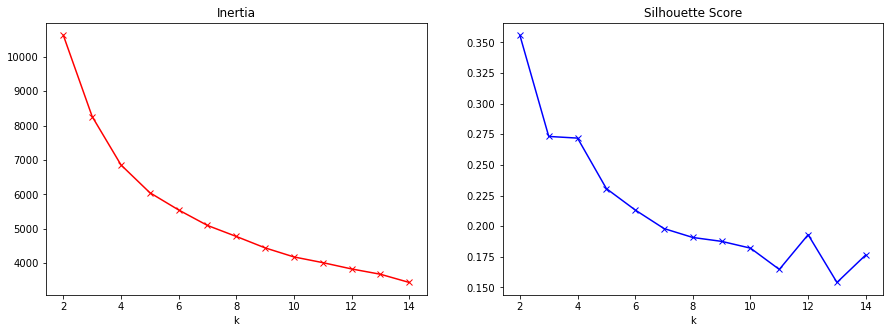

In [6]:
inertias = []
silhouette_scores = []
k_range = range(2, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(dft)
    inertias += [kmeans.inertia_,]
    silhouette_scores += [silhouette_score(dft, labels),]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(k_range, inertias, 'rx-')
ax1.set(xlabel='k', title="Inertia")
ax2.plot(k_range, silhouette_scores,'bx-')
ax2.set(xlabel='k', title="Silhouette Score")
plt.show()

## User-defined values

In [7]:
# Manually select k based on visual inspection above
global_k = 4

# Classification colors (include k colors, or use colormap string)
colormap = matplotlib.colors.ListedColormap(['yellow', 'red', 'cyan', 'orange'])

# Fit and classify using k-means

In [8]:
kmeans = KMeans(n_clusters=global_k, random_state=0)
labels = kmeans.fit_predict(dft)
print_label_counts(labels, colormap)

Class 0 (yellow): 75 (45.45%)
Class 1 (red): 8 (4.85%)
Class 2 (cyan): 26 (15.76%)
Class 3 (orange): 56 (33.94%)


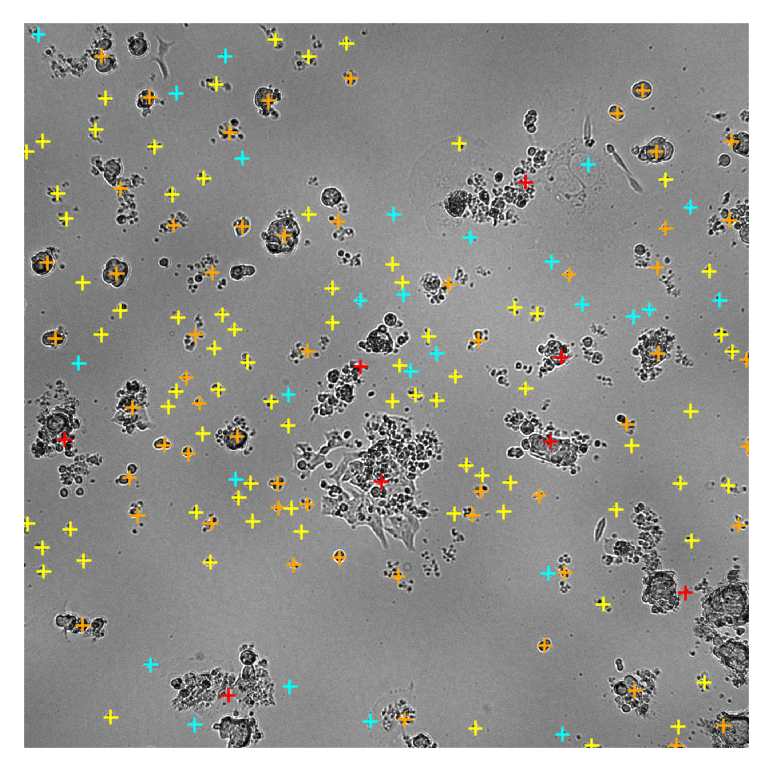

In [9]:
display_classifications(image_gray, dft.index, labels, colormap)

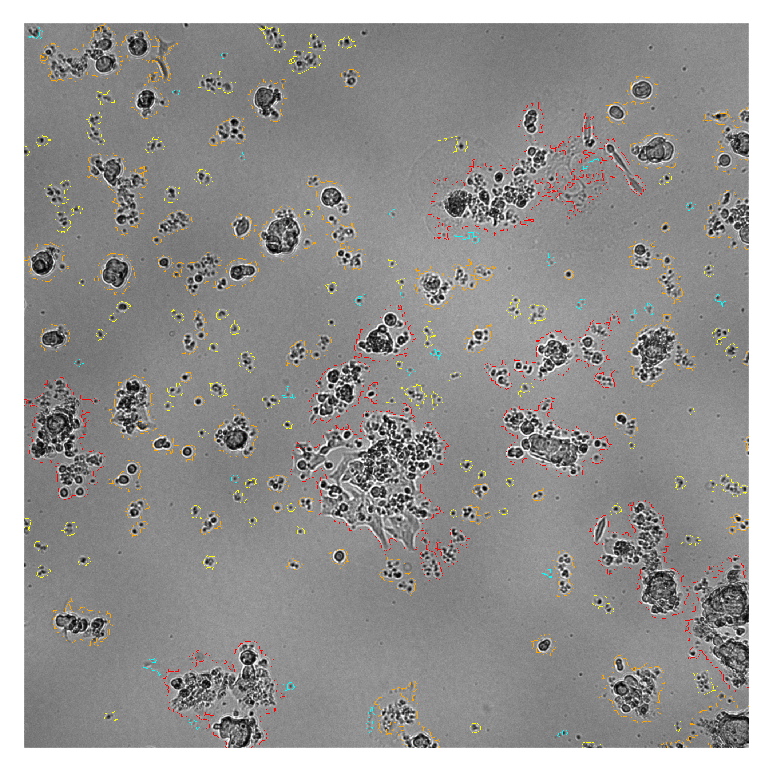

In [10]:
display_image(get_contoured_image(image_gray, mask_labels, labels, colormap))

Unfortunately `sklearn` doesn't let us set a colormap here so disregard the inconsistent coloring.

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


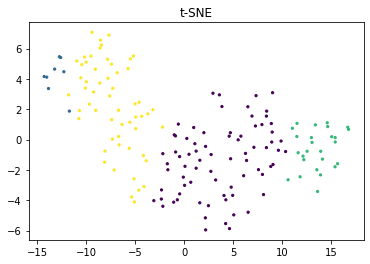

In [11]:
display_tsne(dft, labels)

# Estimate feature importance

In [12]:
num_features = 3

for k in range(labels.max()+1):
    y = np.uint8(labels==k)
    lr = LogisticRegression().fit(scaled, y)
    sorted_features = [(y, x) for x, y in sorted(zip(lr.coef_[0], df.columns))]
    print("Class %i:" % k)
    for feature, coeff in sorted_features[-num_features:]:
        print("  %s: %.3f" % (feature.replace("original_", ""), coeff))
    print("  ...")
    for feature, coeff in reversed(sorted_features[:num_features]):
        print("  %s: %.3f" % (feature.replace("original_", ""), coeff))

Class 0:
  glszm_LargeAreaHighGrayLevelEmphasis: 0.551
  shape2D_Sphericity: 0.561
  ngtdm_Strength: 0.621
  ...
  glrlm_LongRunLowGrayLevelEmphasis: -0.729
  gldm_DependenceNonUniformityNormalized: -0.775
  glcm_ClusterProminence: -1.075
Class 1:
  glrlm_RunLengthNonUniformity: 0.325
  glszm_SizeZoneNonUniformity: 0.345
  glszm_GrayLevelNonUniformity: 0.345
  ...
  glcm_Idn: -0.105
  shape2D_Sphericity: -0.135
  shape2D_Elongation: -0.184
Class 2:
  glszm_SizeZoneNonUniformityNormalized: 0.369
  ngtdm_Coarseness: 0.371
  gldm_LargeDependenceLowGrayLevelEmphasis: 0.388
  ...
  glcm_JointAverage: -0.277
  glcm_InverseVariance: -0.295
  ngtdm_Contrast: -0.302
Class 3:
  gldm_DependenceVariance: 0.638
  ngtdm_Complexity: 0.663
  glszm_ZoneEntropy: 0.848
  ...
  glcm_ClusterShade: -0.761
  glszm_GrayLevelNonUniformity: -0.863
  glszm_SizeZoneNonUniformity: -1.378


# Classify whole image stack

In [13]:
gray_images = list(map(scale_image, image_stack[1::3]))
fluor_images_1 = image_stack[0::3]
fluor_images_2 = image_stack[2::3]

## Extract raw features in parallel

`get_mask_image` and `extract_features` are the most computationally expensive operations, and conveniently are also very easy to parallelize.

This cuts down runtime by >50%. Note that `tqdm` tracks process initiation, not completion, but this is a cheap and easy way to track progress.

In [14]:
def ef_parallel(image_gray):
    mask_image = get_mask_image(image_gray, 'params_gray_mask.yml')
    df, mask_labels = extract_features(image_gray, mask_image)
    return df, mask_labels

In [15]:
result = Parallel(n_jobs=cpu_count())(delayed(ef_parallel)(ig) for ig in tqdm(gray_images))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [27:02<00:00, 17.27s/it]


## Pickle result in case kernel is lost
This takes up ~2GB on disk with `suspension_colour.tiff`, so don't do this automatically.

In [16]:
# with open("result.pickle", "wb") as outfile:
#     pickle.dump(result, outfile)

# with open("result.pickle", "rb") as infile:
#     result = pickle.load(infile)

## Process features, cluster using k-means, extract analysis data

This expects that the models have been trained in the cells above - we'll re-transform the first image but that's okay.

In [17]:
def eflr_parallel(k, labels, mask_labels, flr_image_1, flr_image_2, max_1, max_2):
    masks = np.array([np.uint8(mask_labels==idx) for idx in np.where(labels==k)[0]+1])
    sizes = list(map(np.sum, masks))
    combined_mask = np.bitwise_or.reduce(masks, axis=0)
    # do some magic arithmetic here to handle 0 values
    combined_mask = np.int16(combined_mask) * 2 - 1
    c1 = Counter(((combined_mask * (np.int16(flr_image_1)+5))-5).flatten())
    c2 = Counter(((combined_mask * (np.int16(flr_image_2)+5))-5).flatten())
    intensities = [c1[a] for a in range(max_1)], [c2[a] for a in range(max_2)]
    return np.sum(sizes), int(np.mean(sizes)), np.array(intensities, dtype=int)

Image 0:


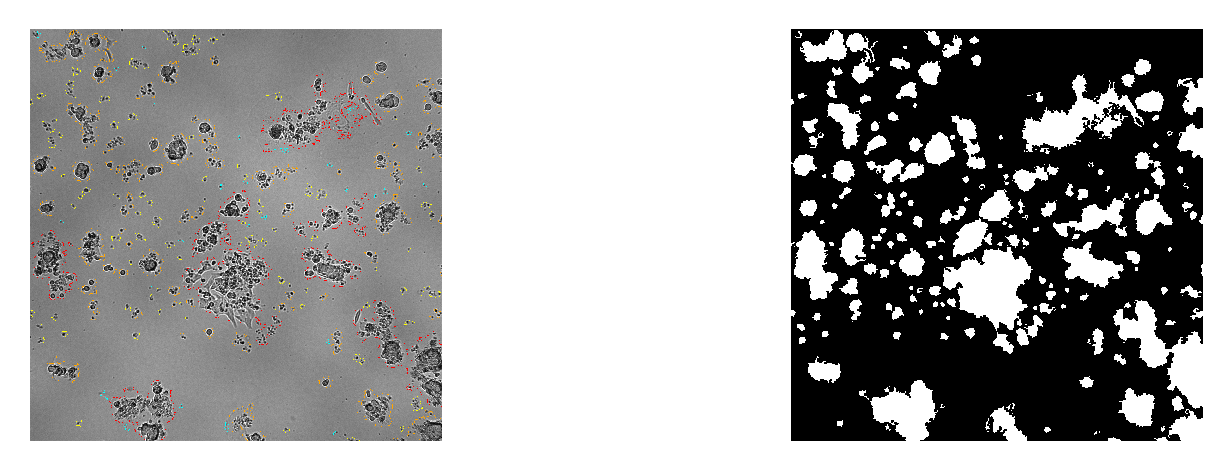

Image 15:


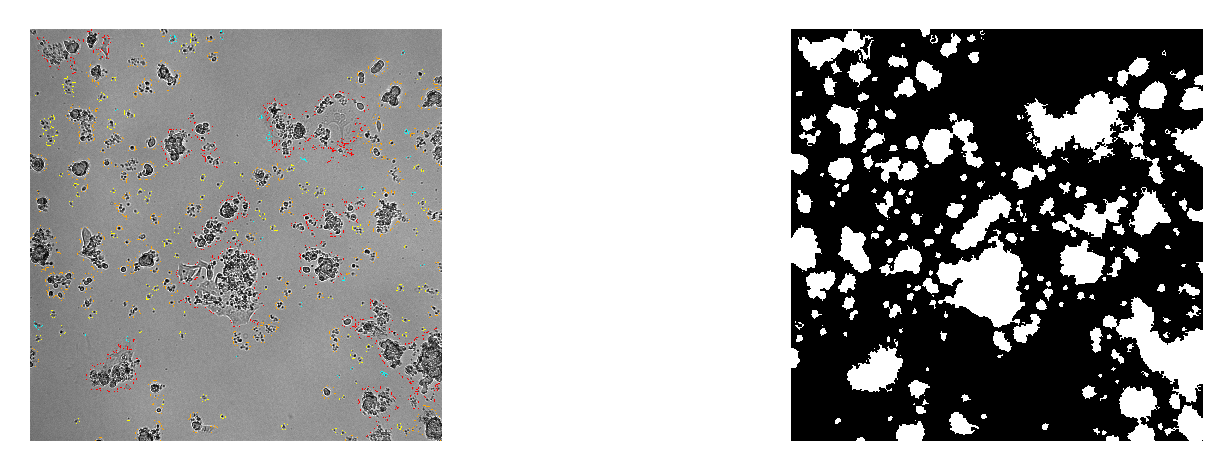

Image 30:


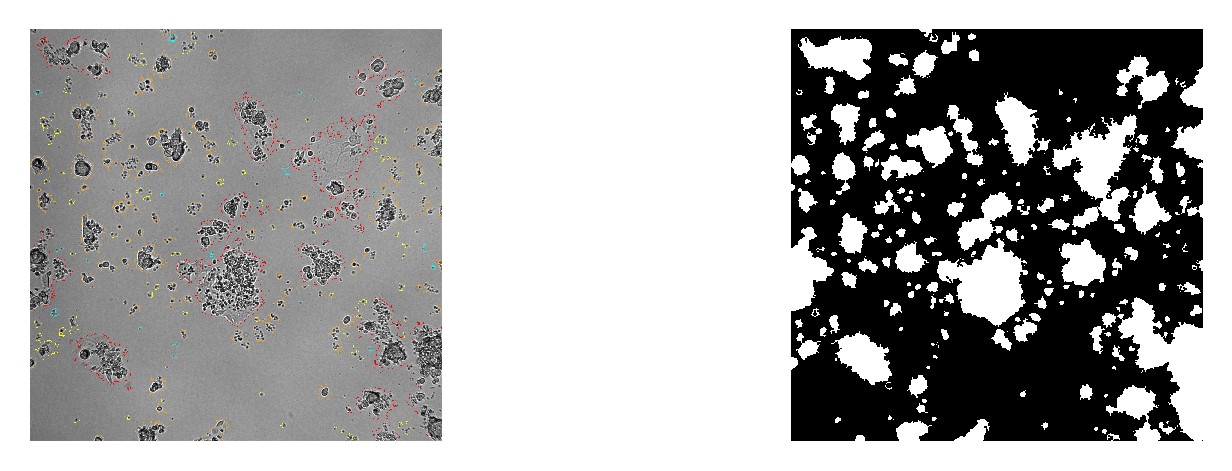

Image 45:


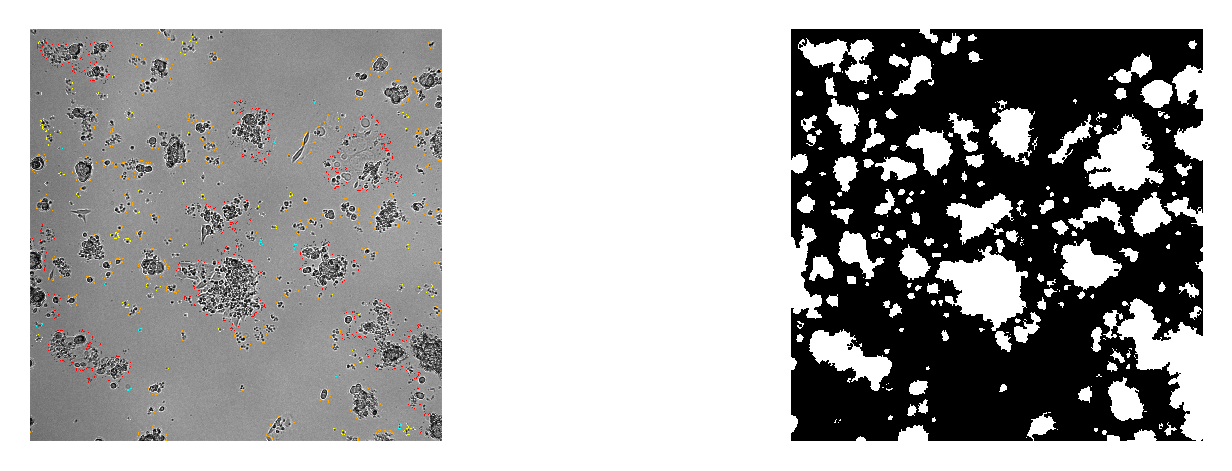

Image 60:


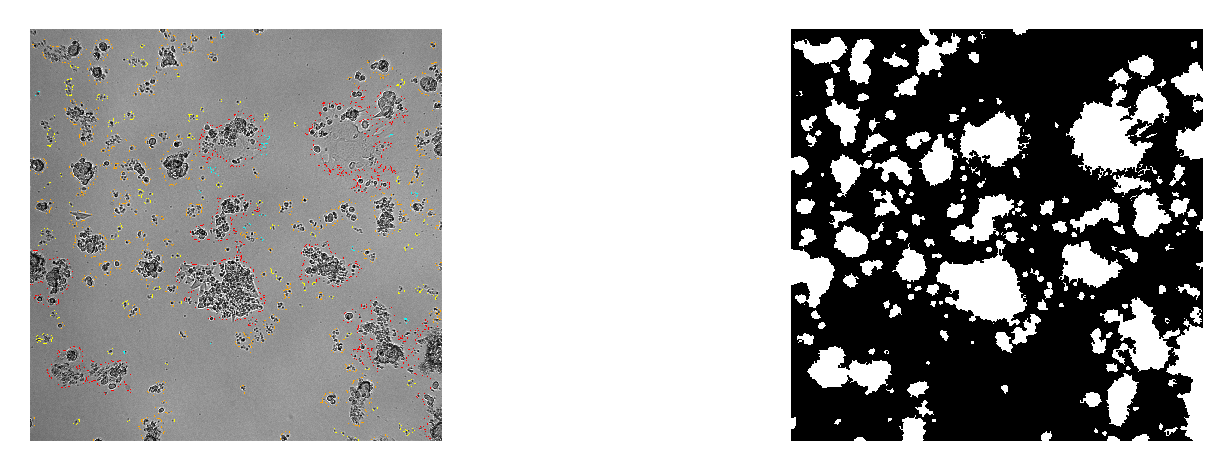

Image 75:


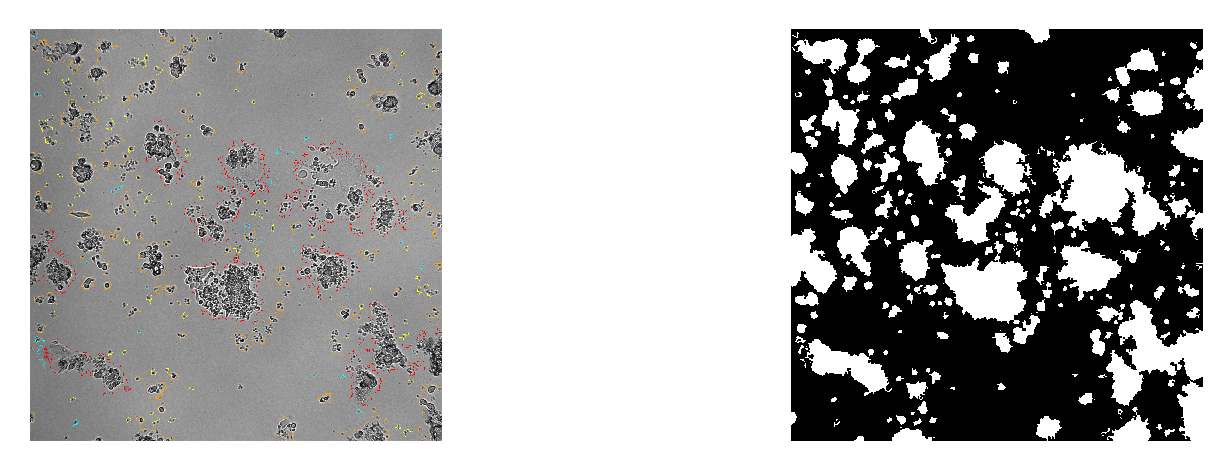

Image 90:


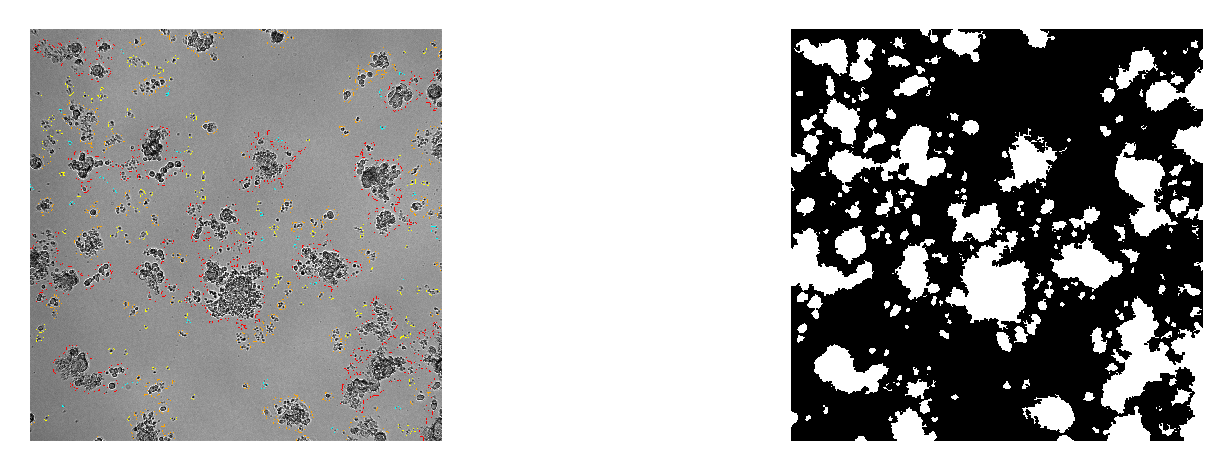

In [18]:
counts = []
total_sizes = []
mean_sizes = []
intensities_1 = []
intensities_2 = []

max_1 = np.array(fluor_images_1).max()
max_2 = np.array(fluor_images_2).max()

# for every image in the image stack
for i in range(len(result)):
    df, mask_labels = result[i]

    # Preprocess features
    df = pd.DataFrame(pca.transform(scaler.transform(df)), index=df.index)
    
    # Cluster using k-means
    labels = kmeans.predict(df)
    
    # Count classes
    counts += [[a[1] for a in sorted(Counter(labels).items(), key=lambda a: a[0])],]

    # Extract size & fluorescence data
    # NOTE: This step is parallelized since it's most computationally expensive by far, due
    # to the mask generation. This cuts down runtime by ~55%. We can consider parallelizing
    # by image frame but we'll have to look into copying sklearn models. We can also nest
    # generators rather than making identical copies of images but the number of copies is
    # small enough that this shouldn't be an important issue.
    nc = kmeans.get_params()['n_clusters']
    args = zip(range(nc), [labels]*nc, [mask_labels]*nc, [fluor_images_1[i]]*nc,
               [fluor_images_2[i]]*nc, [max_1]*nc, [max_2]*nc)
    fl_result = Parallel(n_jobs=cpu_count())(delayed(eflr_parallel)(*a) for a in args)
    fl_result = np.array(fl_result, dtype=object)
    total_sizes += [fl_result[:,0],]
    mean_sizes += [fl_result[:,1],]
    intensities = np.array([_ for _ in fl_result[:,2]], dtype=int)
    intensities_1 += [intensities[:,0,:],]
    intensities_2 += [intensities[:,1,:],]
    
    # Display sanity check images
    if i % 15 == 0:
        print("Image %i:" % i)
        contour_image = get_contoured_image(gray_images[i], mask_labels, labels, colormap)
        display_image_array([contour_image, np.uint8(mask_labels!=0)], columns=2, dpi=300)

counts = np.array(counts).T
total_sizes = np.array(total_sizes, dtype=int).T
mean_sizes = np.array(mean_sizes, dtype=int).T
intensities_1 = np.swapaxes(np.array(intensities_1), 0, 1)
intensities_2 = np.swapaxes(np.array(intensities_2), 0, 1)

## Plot class distributions

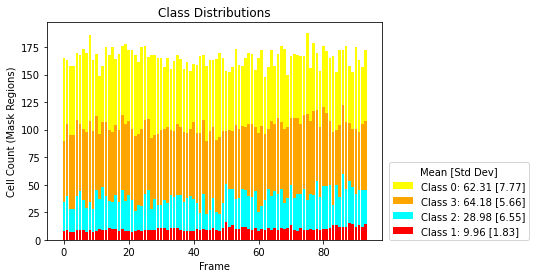

In [19]:
sorted_data = sorted(zip(counts, list(range(len(counts))),
                         np.mean(counts, axis=1), np.std(counts, axis=1)),
                     key=lambda a: a[0][0])
bottom = np.zeros(counts.shape[1])
handles = []
plt.figure()
plt.title("Class Distributions")
plt.ylabel("Cell Count (Mask Regions)")
plt.xlabel("Frame")
for c, k, _, _ in sorted_data:
    handles += [plt.bar(range(len(c)), c, bottom=bottom, color=colormap.colors[k]),]
    bottom += c
plt.legend(reversed(handles),
           [("Class %i: %.2f [%.2f]" % a[1:]) for a in reversed(sorted_data)],
           title="Mean [Std Dev]", loc=(1.02, 0))
plt.show()

## Plot class sizes

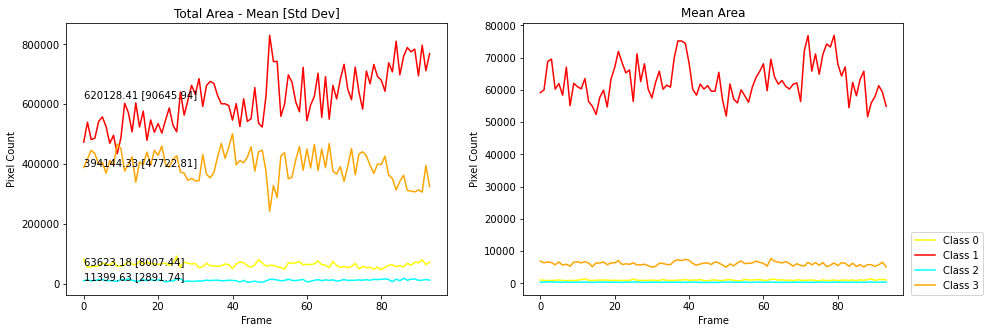

In [20]:
meanstd = list(zip(np.mean(total_sizes, axis=1), np.std(total_sizes, axis=1)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.set_title("Total Area - Mean [Std Dev]")
ax1.set_ylabel("Pixel Count")
ax1.set_xlabel("Frame")
for k in range(len(total_sizes)):
    ax1.plot(total_sizes[k], color=colormap.colors[k], label=("Class %i" % k))
    ax1.annotate(("%.2f [%.2f]" % meanstd[k]), (0, meanstd[k][0]))

ax2.set_title("Mean Area")
ax2.set_ylabel("Pixel Count")
ax2.set_xlabel("Frame")
for k in range(len(mean_sizes)):
    ax2.plot(mean_sizes[k], color=colormap.colors[k], label=("Class %i" % k))
plt.legend(loc=(1.02, 0))

plt.show()

## Plot fluorescence heatmaps

We plot raw counts of pixels here. We can also plot % of pixels (within the class area) using the code below but that gives us a visually near-identical heatmap.
```
prop_1 = np.divide(intensities_1, np.expand_dims(total_sizes, 2))
prop_2 = np.divide(intensities_2, np.expand_dims(total_sizes, 2))
```

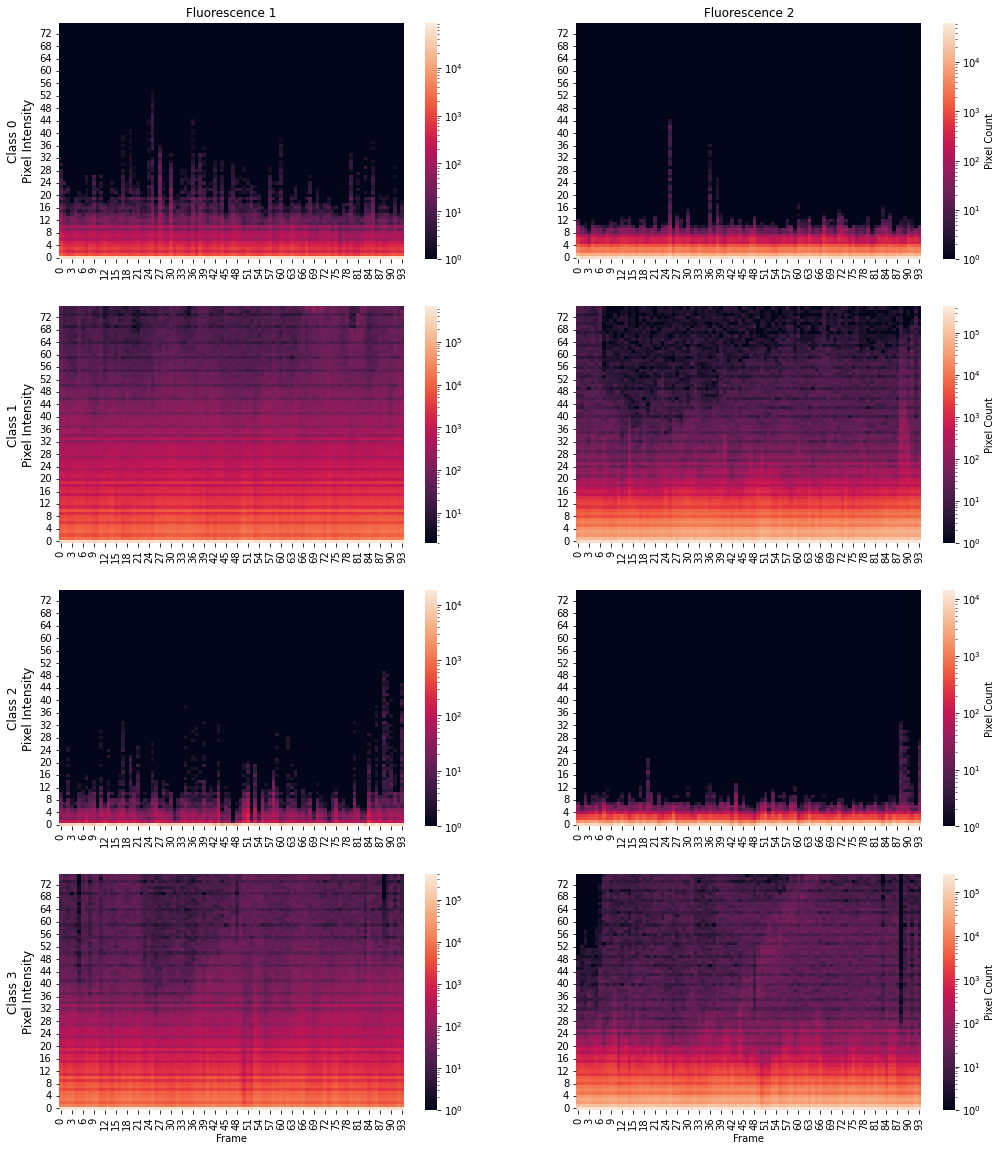

In [21]:
fig, axs = plt.subplots(intensities_1.shape[0], 2, figsize=(17,20))
axs[0,0].set_title("Fluorescence %i" % 1)
axs[0,1].set_title("Fluorescence %i" % 2)

for i in range(intensities_1.shape[0]):
    # Adding 1 here is a hacky trick to avoid taking the log of 0
    sns.heatmap(intensities_1[i].T+1, ax=axs[i,0], norm=matplotlib.colors.LogNorm())
    sns.heatmap(intensities_2[i].T+1, ax=axs[i,1], norm=matplotlib.colors.LogNorm(),
                cbar_kws={'label': "Pixel Count"})
    axs[i,0].set_ylabel(("Class %i\nPixel Intensity" % i), size='large')
    axs[i,0].invert_yaxis()
    axs[i,1].invert_yaxis()
    if i == intensities_1.shape[0]-1:
        axs[i,0].set_xlabel("Frame")
        axs[i,1].set_xlabel("Frame")

## Plot fluorescence percentiles

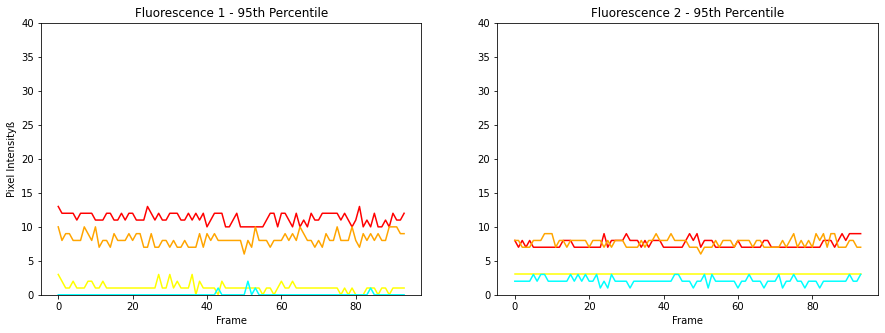

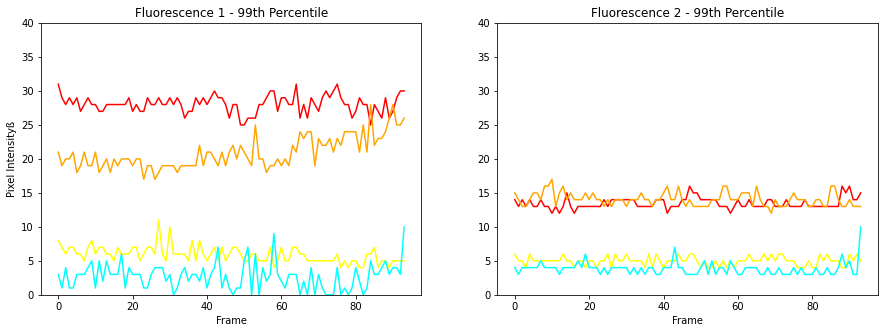

In [22]:
def get_perc_val_from_counts(counts, percentile):
    pidx = int(sum(counts) * percentile / 100)
    for i in range(len(counts)):
        if pidx > counts[i]:
            pidx -= counts[i]
        else:
            return i

def plot_fluorescence(intensities_1, intensities_2, percentile=50):
    perc_values_1 = np.zeros((intensities_1.shape[1], intensities_1.shape[0]))
    for i in range(intensities_1.shape[1]):
        perc_values_1[i] = list(map(get_perc_val_from_counts,
                                    intensities_1[:,i,:], [percentile]*len(intensities_1)))
    perc_values_1 = perc_values_1.T

    perc_values_2 = np.zeros((intensities_2.shape[1], intensities_2.shape[0]))
    for i in range(intensities_2.shape[1]):
        perc_values_2[i] = list(map(get_perc_val_from_counts,
                                    intensities_2[:,i,:], [percentile]*len(intensities_2)))
    perc_values_2 = perc_values_2.T

    plt.figure(figsize=(15, 5))
    for i in range(len(perc_values_1)):
        plt.subplot(1,2,1)
        plt.plot(perc_values_1[i], color=colormap.colors[i])
        plt.title("Fluorescence 1 - %ith Percentile" % percentile)
        plt.ylabel("Pixel Intensityß")
        plt.xlabel("Frame")
        plt.ylim(0, 40)

        plt.subplot(1,2,2)
        plt.plot(perc_values_2[i], color=colormap.colors[i])
        plt.title("Fluorescence 2 - %ith Percentile" % percentile)
        plt.xlabel("Frame")
        plt.ylim(0, 40)
    plt.show()

plot_fluorescence(intensities_1, intensities_2, 95)
plot_fluorescence(intensities_1, intensities_2, 99)